# Формирование модели монетизации мобильной игры

# Материалы

[Ссылка](https://drive.google.com/file/d/1KJy2YXMHvb_pCWTs41xrZ_cp_LbCd6l0/view?usp=share_link) на презентацию с выводами по исследованию

[Ссылка](https://public.tableau.com/views/Book3_16801811305550/sheet2?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link) на дашборд

# Введение

**Название проекта:** Формирование модели монетизации мобильной игры

**Описание проекта:** Разработчики запустили мобильную игру "Космические братья". В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики. Первые пользователи уже играют, и их привлечение работает. Однако, пока не реализована основная монетизация игры: предполагается, что это будет показ рекламы на одном из экранов. В такой механике есть противоречие: если показать рекламу рано, то пользователь может разозлиться и уйти, если поздно - тем меньше игроков останется и принесут разработчикам меньше денег. Перед аналитиком стоит задача выбора оптимального времени для показа рекламы. Требования к решению: реклама должна окупать привлечение пользователей по достижению ими первого уровня, количество рекламы должно быть минимально.

**Цель:** на основании минимальной окупаемости привлечения игроков определить оптимальное время для показа внутриигровой рекламы.

**Гипотезы:**
1. Время прохождения уровня между игроками, которые реализуют проект или побеждают игрока для перехода к следующему уровню, равно или отличается
2. Количество построек не зависит от стиля игры, а значит строители и воины будут видеть одинаковое количество рекламы

**Задачи:**
1. Загрузить и преобработать данные
    1. Типы данных
    2. Дубликаты
    3. Пропуски
    4. Аномалии
    5. Горизонт анализа (оставить актуальные данные)
    6. Коррекция даты закупки рекламы (закупка на день опережает привлечение)
2. Провести исследовательский анализ данных
    1. Что влияет на целевое событие "Игрок перешел на новый уровень"?
        1. Связь перехода на новый уровень и даты привлечения пользователя
        2. Связь перехода на новый уровень и канала привлечения пользователя
        3. Связь перехода на новый уровень и количества построенных объектов
        4. Связь перехода на новый уровень и типов построенных объектов
        5. Связь перехода на новый уровень и тип игры - строитель или воин
    2. Какое событие выбрать для показа рекламы?
        1. расчет затрат на привлечение пользователей по когортам
        2. количество событий в датасете в разбивке по разным пользователям и когортам
        3. расчет предполагаемых доходов от показов рекламы из расчета 0.07 у.е. за показ
        4. выбор событий для показа рекламы
3. Проверить статистические гипотезы
    1. Подготовить данные
    2. Правильно выбрать тест и проверить, нужна ли поправка
4. Сформулировать выводы и рекомендации, подготовить презентацию

**Исходные данные:** Исходные данные предоставлены разработчиками и содержат 3 таблицы:
* game_actions.csv с логами внутриигровых событиях о построках, проектах и завершениях уровня, типах построек
* ad_costs.csv с информацией о рекламных активностях: день, источник трафика, стоимость кликов
* user_source.csv с информацией о пользователях и источниках их привлечения

**Форма представления результатов:** по итогам исследования подготовить презентацию с обоснованием выбора оптимальной модели монетизации игры в формате pdf

# Loading libraries and hard variables

In [1]:
# # обновление библиотеки
# !pip install matplotlib --upgrade
# !pip install pandas==1.3.2

     |████████████████████████████████| 11.6 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 68.1 MB/s eta 0:00:01
     |████████████████████████████████| 299 kB 105.4 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
     |████████████████████████████████| 11.5 MB 1.2 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4


In [2]:
# загрузка библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import datetime
import math
import scipy.stats as stats




# задание хард-переменных
# выручка за один показ рекламы внутри игры
inner_ad_price = 0.07

# Загрузка и предобработка данных

In [3]:
# датасет по маркетингу
try:
    try:
        ad_costs = pd.read_csv('/Users/glebderabin/Мой диск/ЯПрактикум/финальный проект/проект/ad_costs.csv')
    except:
        ad_costs = pd.read_csv(r"C:\Users\Gleb\Мой диск\ЯПрактикум\финальный проект\проект\ad_costs.csv")
except:
    ad_costs = pd.read_csv('/datasets/ad_costs.csv')

# датасет с логами игры
try:
    try:
        game_actions = pd.read_csv('/Users/glebderabin/Мой диск/ЯПрактикум/финальный проект/проект/game_actions.csv')
    except:
        game_actions = pd.read_csv(r"C:\Users\Gleb\Мой диск\ЯПрактикум\финальный проект\проект\game_actions.csv")
except:
    game_actions = pd.read_csv('/datasets/game_actions.csv')

# датасет с логами игры
try:
    try:
        user_source = pd.read_csv('/Users/glebderabin/Мой диск/ЯПрактикум/финальный проект/проект/user_source.csv')
    except:
        user_source = pd.read_csv(r"C:\Users\Gleb\Мой диск\ЯПрактикум\финальный проект\проект\user_source.csv")
except:
    user_source = pd.read_csv('/datasets/user_source.csv')

## Предобработка таблицы ad_costs

    1. Типы данных
    2. Дубликаты
    3. Пропуски
    4. Аномалии
    5. Горизонт анализа (оставить актуальные данные)
    6. Коррекция даты закупки рекламы (закупка на день опережает привлечение)

In [4]:
display(ad_costs.head())
display(ad_costs.info())
display(ad_costs.describe())
print('Количество пропусков в таблице: ', ad_costs.isnull().sum().sum()) 
print('Количество полных дубликатов строк в таблице: ', ad_costs.duplicated().sum())

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

,cost
count,28.000000
mean,271.556321
std,286.867650
min,23.314669
25%,66.747365
50%,160.056443
75%,349.034473
max,969.139394


Количество пропусков в таблице:  0
Количество полных дубликатов строк в таблице:  0


В таблице 28 строк, описывающих маркетинговые затраты на привлечение пользователей в разбивке по дням и каналам. В таблице нет пропусков и дубликатов. На первый взгляд, аномалий тоже нет. Нужно привести поле day к правильному формату и добавить к значениям один день: от отдела маркетинга известно, что пользователи приходят на следующий день после оплаты рекламы

In [5]:
# тип поля - метка времени
ad_costs['day'] = pd.to_datetime(ad_costs['day'])
# добавляю один день к каждой записи
ad_costs['day'] = ad_costs['day'] + pd.Timedelta(days=1)

## Предобработка таблицы game_actions

In [6]:
display(game_actions.head())
display(game_actions.info())
display(game_actions.describe())
print('Количество пропусков в таблице: ', game_actions.isnull().sum().sum()) 
print('Количество полных дубликатов строк в таблице: ', game_actions.duplicated().sum())

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-09 12:35:56,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,satellite_orbital_assembly
freq,4,127957,59325,22,1866


Количество пропусков в таблице:  141457
Количество полных дубликатов строк в таблице:  1


Таблица game_actions содержит в себе 135640 записей с полями времени, типе события, типе постройки, индентификаторе пользователя, постройке проекта.
В поле building_type есть пропуски, нужно проверить, что они связаны с другими типами событий, а не с некорректным сбором данных. Пропуски в поле project_type связаны с тем, что для окончания уровня и в принципе для игры не обязательно строить проект. На первый взгляд аномалий нет.
Самый активный пользователь сгенерировал 22 события. Поле event_datetime нужно привести к правильному типу. Обнаружен один полный дубликат.

In [7]:
# привожу event_datetime к правильному типу
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])

# проверяю пропуски в поле building_type, если event == building
game_actions[game_actions['event'] == 'building']['building_type'].isnull().sum()

0

In [8]:
# проверяю полный дубликат
game_actions[game_actions.duplicated()]

,event_datetime,event,building_type,user_id,project_type
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


Маловероятно, что пользователь построил два исследовательских центра в одну секунду. Хотя это не повлияет на исследование, отброшу дубликат

In [9]:
game_actions.drop_duplicates(inplace=True, ignore_index=True)

## Предобработка таблицы user_source

    1. Типы данных
    2. Дубликаты
    3. Пропуски
    4. Аномалии
    5. Горизонт анализа (оставить актуальные данные)
    6. Коррекция даты закупки рекламы (закупка на день опережает привлечение)

In [10]:
display(user_source.head())
display(user_source.info())
display(user_source.describe())
print('Количество пропусков в таблице: ', user_source.isnull().sum().sum()) 
print('Количество полных дубликатов строк в таблице: ', user_source.duplicated().sum())

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


None

,user_id,source
count,13576,13576
unique,13576,4
top,0001f83c-c6ac-4621-b7f0-8a28b283ac30,yandex_direct
freq,1,4817


Количество пропусков в таблице:  0
Количество полных дубликатов строк в таблице:  0


В таблице собрана информация о том, из каких источников пришли пользователи. Пропусков нет, все типы данных верные. Каждый пользователь встречается один раз. Каналов всего 4. В игру привлекли 13576 пользователей, а с этой таблицей все в порядке

## Выводы по предобработке

Данные в порядке. Изменен тип временных данных, удален один дубликат. Большая предобработка не требуется

# Исследовательский анализ данных

## Что влияет на целевое событие "Игрок перешел на новый уровень"?

Для начала узнаем, сколько всего игроков привлекли, сколько совершили хотя бы одной действие и сколько закончили первый уровень, то есть получили событие finished_stage_1

In [11]:
print('Кол-во привлеченных игроков: ', len(user_source['user_id'].unique()))
print('Кол-во игроков, зарегистрировавших хотя бы одно событие: ', len(game_actions['user_id'].unique()))
print('Кол-во игроков, закончивших первый уровень: ', len(game_actions[game_actions['event']=='finished_stage_1']['user_id'].unique()))

Кол-во привлеченных игроков:  13576
Кол-во игроков, зарегистрировавших хотя бы одно событие:  13576
Кол-во игроков, закончивших первый уровень:  5817


Каждый, кого отдел маркетинга привел в игру, совершил в ней хоть какое-то действие. Отлично! А почти 6000 игроков закончили первый уровень. Чтобы изучить влияние разных факторов на совершение целевого действия (завершение уровня), создам специальную таблицу для исследования

In [12]:
# в качестве базовой буду использовать таблицу user_source, в ней есть все пользователи и их источник
data_explore_1 = user_source

# к таблице добавлю время первого и последнего взаимодействия пользователя с игрой
data_explore_1 = data_explore_1.merge(
    right=(game_actions.groupby('user_id').agg({'event_datetime': 'min'})),
    on='user_id'
)
data_explore_1.rename(columns={'event_datetime': 'min_dt'}, inplace=True)
data_explore_1['min_day'] = data_explore_1['min_dt'].dt.normalize()

data_explore_1 = data_explore_1.merge(
    right=(game_actions.groupby('user_id').agg({'event_datetime': 'max'})),
    on='user_id'
)
data_explore_1.rename(columns={'event_datetime': 'max_dt'}, inplace=True)
data_explore_1['max_day'] = data_explore_1['max_dt'].dt.normalize()

# к таблице добавлю информацию о завершении уровня
finished_list = game_actions.query('event == "finished_stage_1"')['user_id'].unique()
data_explore_1['is_level_finished'] = data_explore_1['user_id'].apply(lambda x: True if x in finished_list else False)

# к таблице добавляю информацию об отметке времени завершения уровня
# оказалось, что она совпадает с max_dt для тех, кто закончил уровень
data_explore_1 = pd.merge(data_explore_1,
                          (game_actions.query('event == "finished_stage_1"')[['user_id', 'event_datetime']]),
                          on='user_id', how='left')

data_explore_1.rename(columns={'event_datetime': 'dt_level_finished'}, inplace=True)

# к таблице добавляю инормацию о кол-ве времени для завершения уровня
data_explore_1['time_for_level'] = data_explore_1['dt_level_finished'] - data_explore_1['min_dt']
data_explore_1['time_for_level'] = data_explore_1['time_for_level'].astype('timedelta64[m]')

# к таблице присоединяю кол-во построек
data_explore_1 = data_explore_1.merge(
    right=(game_actions.groupby('user_id').agg({'building_type': 'count'})),
    on='user_id'
)
data_explore_1.rename(columns={'building_type': 'n_builded'}, inplace=True)

# к таблице добавлю информацию о типе игрока. Если он закончил уровень через
# событие project в поле event - то он строитель, если нет - воин. Если нет ни в одном списке - не закончил уровень
builders_id_list = game_actions.query('event == "project"')['user_id'].unique()
varriors_id_list = game_actions.query('event == "finished_stage_1" and user_id not in @builders_id_list')['user_id'].unique()
data_explore_1['game_style'] = data_explore_1['user_id'].apply(lambda x: 'builder' if x in builders_id_list else ('varrior' if x in varriors_id_list else 'not_finished'))

data_explore_1

,user_id,source,min_dt,min_day,max_dt,max_day,is_level_finished,dt_level_finished,time_for_level,n_builded,game_style
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06 01:07:37,2020-05-06,2020-05-20 11:26:06,2020-05-20,False,NaT,NaN,13,not_finished
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct,2020-05-06 03:09:12,2020-05-06,2020-05-18 10:46:52,2020-05-18,False,NaT,NaN,9,not_finished
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama,2020-05-05 18:08:52,2020-05-05,2020-05-14 09:21:27,2020-05-14,False,NaT,NaN,4,not_finished
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts,2020-05-05 21:02:05,2020-05-05,2020-05-12 07:40:47,2020-05-12,True,2020-05-12 07:40:47,9278.0,8,varrior
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads,2020-05-05 13:49:58,2020-05-05,2020-05-22 02:46:45,2020-05-22,False,NaT,NaN,12,not_finished
...,...,...,...,...,...,...,...,...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts,2020-05-04 01:58:59,2020-05-04,2020-05-11 22:15:54,2020-05-11,True,2020-05-11 22:15:54,11296.0,9,varrior
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads,2020-05-04 11:58:14,2020-05-04,2020-05-14 10:11:36,2020-05-14,False,NaT,NaN,16,not_finished
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct,2020-05-04 02:05:09,2020-05-04,2020-05-12 13:01:52,2020-05-12,True,2020-05-12 13:01:52,12176.0,9,varrior
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts,2020-05-04 20:28:28,2020-05-04,2020-05-11 22:04:30,2020-05-11,False,NaT,NaN,7,not_finished


### Связь перехода на новый уровень и даты привлечения пользователя

Для этого группирую таблицу по датам первого взаимодействия с игрой и считаю долю завершивших уровень. Для визуализации буду использовать столбчатую диаграмму

is_level_finished      
                        mean   sum
min_day                           
2020-05-04          0.455631  2670
2020-05-05          0.450164  1513
2020-05-06          0.417434   771
2020-05-07          0.371506   412
2020-05-08          0.341570   235
2020-05-09          0.304545   134
2020-05-10          0.302583    82

Text(0, 0.5, 'Доля от общего количества')

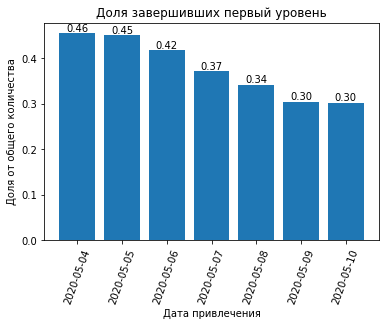

In [13]:
# группировка
temp_df = data_explore_1.groupby('min_day').agg({'is_level_finished': [np.mean, np.sum]})
display(temp_df)

# визуализация
fig, ax = plt.subplots()
plt.xticks(rotation=70)
ax.bar(x=temp_df.index, height=temp_df['is_level_finished']['mean'])
plt.bar_label(ax.containers[0], fmt='%.2f')
ax.set_title('Доля завершивших первый уровень')
ax.set_xlabel('Дата привлечения')
ax.set_ylabel('Доля от общего количества')

Новые игроки приходили в игру с 4 по 10 мая. Логи игры охватывают период до 5 июня. Столбчатая диаграмма показывает, что доля игроков, завершивших уровень, постепенно снижается с 0,46 до 0,3. Это может быть связано с тем, что логи охватывают недостаточный период для завершения уровня игроками, привлеченными в конце маркетинговых активностей, и в действительности доля завершивших уровень не зависит от дня привлечения пользователя. Исследуем это

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


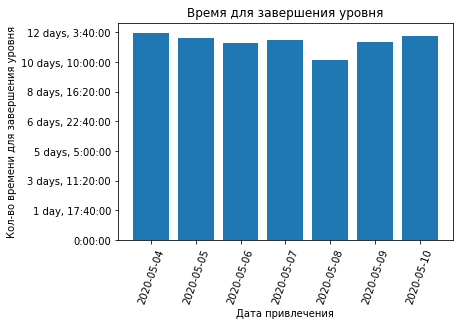

In [14]:
# группировка
temp_df = data_explore_1.groupby('min_day').mean(numeric_only=False)

# визуализация
fig, ax = plt.subplots()
plt.xticks(rotation=70)
ax.bar(x=temp_df.index, height=temp_df['time_for_level'])
ax.set_title('Время для завершения уровня')
ax.set_xlabel('Дата привлечения')
ax.set_ylabel('Кол-во времени для завершения уровня')
def timeTicks(x, pos):                                                                                                                                                                                                                                                         
    d = datetime.timedelta(minutes=x)                                                                                                                                                                                                                                          
    return str(d)                                                                                                                                                                                                                                                              
formatter = matplotlib.ticker.FuncFormatter(timeTicks)                                                                                                                                                                                                                         
ax.yaxis.set_major_formatter(formatter)  

В среднем прохождение уровня занимает около 11 дней. Кажется, это очень много для одного уровня в мобильной игре. Тем не менее, время незначительно меняется от даты привлечения пользователя, а логи охватывают больший период (31 день после последнего дня привлечения), чем в среднем требуется для завершения уровня. Значит можно предположить, что доля завершивших уровень в зависимости от даты привлечения все же зависит: игроки, привлеченные после 7 мая (закупка рекламы от 6 мая) проходят игру хуже, перестают играть. **Отделу маркетинга на заметку.**

### Связь перехода на новый уровень и канала привлечения пользователя

Проверяю две вещи: время на первый уровень и долю завершивших

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


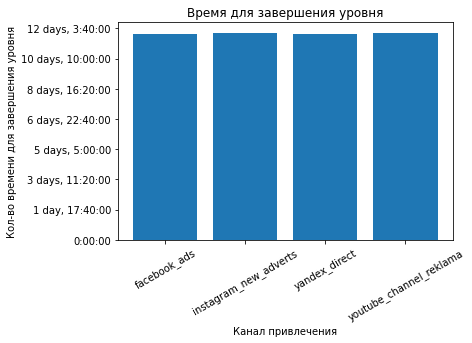

In [15]:
# время на уровень
# группировка
temp_df = data_explore_1.groupby('source').mean(numeric_only=False)

# визуализация
fig, ax = plt.subplots()
plt.xticks(rotation=30)
ax.bar(x=temp_df.index, height=temp_df['time_for_level'])
ax.set_title('Время для завершения уровня')
ax.set_xlabel('Канал привлечения')
ax.set_ylabel('Кол-во времени для завершения уровня')
def timeTicks(x, pos):                                                                                                                                                                                                                                                         
    d = datetime.timedelta(minutes=x)                                                                                                                                                                                                                                          
    return str(d)                                                                                                                                                                                                                                                              
formatter = matplotlib.ticker.FuncFormatter(timeTicks)                                                                                                                                                                                                                         
ax.yaxis.set_major_formatter(formatter)  

Отлично, среднее время не зависит от канала привлечения и сохранилось около 11 дней

is_level_finished      
                                     mean   sum
source                                         
facebook_ads                     0.421864  1150
instagram_new_adverts            0.438004  1466
yandex_direct                    0.423915  2042
youtube_channel_reklama          0.431497  1159

Text(0, 0.5, 'Доля от общего количества')

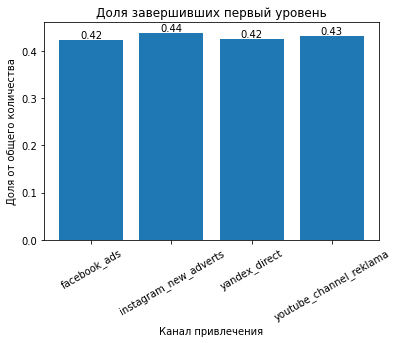

In [16]:
# доля закончивших уровень
# группировка
temp_df = data_explore_1.groupby('source').agg({'is_level_finished': [np.mean, np.sum]})
display(temp_df)

# визуализация
fig, ax = plt.subplots()
plt.xticks(rotation=30)
ax.bar(x=temp_df.index, height=temp_df['is_level_finished']['mean'])
plt.bar_label(ax.containers[0], fmt='%.2f')
ax.set_title('Доля завершивших первый уровень')
ax.set_xlabel('Канал привлечения')
ax.set_ylabel('Доля от общего количества')

Доля завершивших уровень от канала привлечения не зависит.

### Связь перехода на новый уровень и количества построенных объектов

Тут, скорее смотрим на соотношение среднего кол-ва построек у закончивших уровень и не закончивших

,is_level_finished,n_builded
0,False,8.657043
1,True,10.449716


Text(0, 0.5, 'Среднее количество построек')

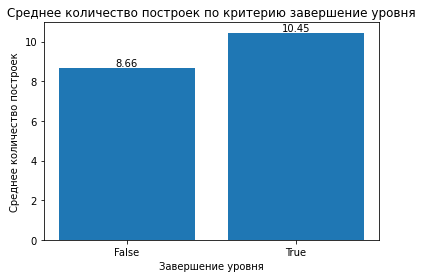

In [17]:
# группирую
temp_df = data_explore_1.groupby('is_level_finished', as_index=False).agg({'n_builded': 'mean'})
display(temp_df)

# визуализирую
fig, ax = plt.subplots()
ax.bar(x=temp_df['is_level_finished'], height=temp_df['n_builded'])
plt.bar_label(ax.containers[0], fmt='%.2f')
plt.xticks([1.0, 0.0], ["True",
                        "False"])
ax.set_title('Среднее количество построек по критерию завершение уровня')
ax.set_xlabel('Завершение уровня')
ax.set_ylabel('Среднее количество построек')

Интересно: кол-во строений незначительно отличается между игроками (если округлять), которые закончили или не закончили уровень. Вероятно, это связано с разными способами закончить уровень. По кол-ву построек нельзя однозначно сказать о достижении целевого параметра.

### Связь перехода на новый уровень и типов построенных объектов

для ответа на этот вопрос я использую столбчатую диаграмму по типам строений, их количеству и отметке о завершении уровня. Для этого буду работать с таблией games_actions и добавлю к ней столбец о завершении уровня

Комментарий студента: apply с lambda мне очень понравились по компактности и простоте, но уж очень небыстрый метод. Может есть что-то оптимальнее?

,building_type,is_level_finished,user_id,event,mean_buildings
0,assembly_shop,False,7759,29080,3.747906
1,assembly_shop,True,5817,25414,4.368919
2,research_center,False,3463,6685,1.930407
3,research_center,True,4208,7452,1.770913
4,spaceport,False,7471,31405,4.203587
5,spaceport,True,5760,27920,4.847222


Text(0, 0.5, 'Кол-во объектов на игрока')

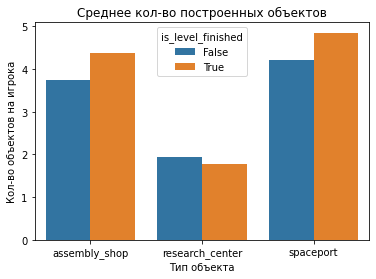

In [18]:
# к таблице добавлю информацию о завершении уровня и группирую в новую таблицу
finished_list = game_actions.query('event == "finished_stage_1"')['user_id'].unique()
temp_df = game_actions
temp_df['is_level_finished'] = temp_df['user_id'].apply(lambda x: True if x in finished_list else False)

temp_df_2 = temp_df.groupby(['building_type', 'is_level_finished'], as_index=False).agg({'user_id': 'nunique', 'event': 'count'})
temp_df_2['mean_buildings'] = temp_df_2['event'] / temp_df_2['user_id']
display(temp_df_2)

# визуализирую
ax = sns.barplot(data=temp_df_2, x='building_type', y='mean_buildings', hue='is_level_finished')
ax.set_title('Среднее кол-во построенных объектов')
ax.set_xlabel('Тип объекта')
ax.set_ylabel('Кол-во объектов на игрока')


Больше всего строят объектов spaceport, затем assembly_shop и меньше всего - research_center. Нам неизвестна точная механика игры (НАДО БЫ УЗНАТЬ) и нельзя сказать, как постройка объектов влияет на реализацию проекта по разработке орбитальной сборки спутников. Если сравнивать кол-во построек по прохождению уровня, то игроки, завершившие уровень, чаще строили assembly_shop и spaceport, реже - research_center. Но отличия небольшие, чтобы сказать, что они определяют завершение уровня. Может быть, люди, не завершившие уровень еще не построили эти объекты.

### Связь перехода на новый уровень и тип игры - строитель или воин

Уровень можно закончить двумя способами - одолев другого игрока в битве или реализовать проект. Рассматривать долю перехода на новый уровень нет смысла - все перейдут на него. Можно посмотреть на время завершения первого уровня и среднее кол-во построек, которое пришлось построить

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


,min_dt,min_day,max_dt,max_day,is_level_finished,dt_level_finished,time_for_level,n_builded
game_style,,,,,,,,
builder,2020-05-05 09:10:51.357984768,2020-05-04 22:33:34.147909888,2020-05-18 20:11:40.493033472,2020-05-18 08:04:37.813505024,1.0,2020-05-18 20:11:40.493033472,19380.327974,12.647910
varrior,2020-05-05 15:00:48.526955008,2020-05-05 04:10:45.102505728,2020-05-16 17:31:12.603138560,2020-05-16 05:34:56.583143424,1.0,2020-05-16 17:31:12.603138560,15989.915211,9.411541
not_finished,2020-05-05 19:49:55.019847936,2020-05-05 08:41:08.359324672,2020-05-15 14:44:53.275293184,2020-05-15 02:35:42.647248384,0.0,NaT,NaN,8.657043


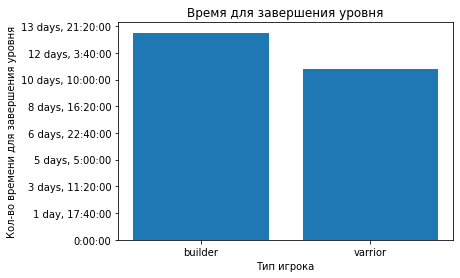

In [19]:
# среднее время на завершение уровня строителями и воинами
# группировка
temp_df = data_explore_1.groupby('game_style').mean(numeric_only=False).sort_values('time_for_level', ascending=False)
display(temp_df)

# визуализация
fig, ax = plt.subplots()
ax.bar(x=temp_df.index, height=temp_df['time_for_level'])
ax.set_title('Время для завершения уровня')
ax.set_xlabel('Тип игрока')
ax.set_ylabel('Кол-во времени для завершения уровня')
def timeTicks(x, pos):                                                                                                                                                                                                                                                         
    d = datetime.timedelta(minutes=x)                                                                                                                                                                                                                                          
    return str(d)                                                                                                                                                                                                                                                              
formatter = matplotlib.ticker.FuncFormatter(timeTicks)                                                                                                                                                                                                                         
ax.yaxis.set_major_formatter(formatter)  


Заметны отличия: pvp игроки завершают уровень в среднем за 11 дней, а строителям нужно почти 14. Воющие игроки добираются до целевого действия быстрее

,game_style,n_builded
0,builder,12.647910
1,not_finished,8.657043
2,varrior,9.411541


Text(0, 0.5, 'Среднее количество построек')

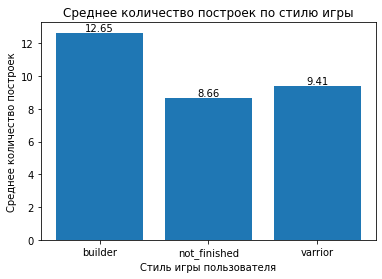

In [20]:
# среднее кол-во зданий строителей и воинов
# группирую
temp_df = data_explore_1.groupby('game_style', as_index=False).agg({'n_builded': 'mean'})
display(temp_df)

# визуализирую
fig, ax = plt.subplots()
ax.bar(x=temp_df['game_style'], height=temp_df['n_builded'])
plt.bar_label(ax.containers[0], fmt='%.2f')
ax.set_title('Среднее количество построек по стилю игры')
ax.set_xlabel('Стиль игры пользователя')
ax.set_ylabel('Среднее количество построек')

Воины и нефинишировшие строят почти одинаковое количество строений - около 9. Но воины - больше (9,4 против 8,6). Видимо, таким количеством построек нужно обладать, чтобы победить другого игрока. Строители располагают большим количеством построек - около 13 на человека. Нелегко завершить проект!

## Выводы по факторам, влияющим на целевое событие

Напомню, что целевым событием в исследовании является завершение первого уровня. Выше исследовались различные факторы, связанные с достижением целевого события. В результате определено:
1. В среднем прохождение уровня занимает 11 дней и это много для мобильной игры (личный опыт). Доля игроков, завершивших уровень - 0,42 от всех.
2. Дата привлечения не влияет на время прохождения уровня, а вот на долю закончивших - да. Нужно обратить внимание отдела маркетинга на то, что игроки, привлеченные после 7 мая (закупка рекламы от 6 мая) проходят игру хуже, перестают играть.
3. Время прохождения уровня и доля победителей не зависит от канала привлечения
4. Среднее количество построек на игрока незначительно отличается у завершивших и еще играющих
5. То же самое с типом - разница между средним количеством построек разных типов незначительна.
6. Воины заканчивают уровень быстрее (11 дней) и имеют меньше построек (9,4), чем строители (почти 14 дней и 12,6 построек).

# Какое событие выбрать для показа рекламы?

Разработчики игры решили, что будут зарабатывать на показе рекламы пользователям при выборе типа постройки здания (результат - лог о постройке здания). Расчет ведется из того, что каждый показ будет приносить 0.07 у.е. (задается в разделе загрузке библиотек и хард-переменных). Цель данного анализа - определить, в каких случаях будет показываться реклама. Требования:
* реклама должна окупать привлечение пользователей за их первый уровень
* количество рекламы должно быть минимальным
* показ рекламы не должен зависить от источника пользователя и как либо дискриминировать его *(в том числе по стилю игры)*

**Размышления**
* Не можем показывать рекламу только тем, кто прошел уровень - мы не знаем кто это будут и выделить по средним не получается
* Не можем показывать рекламу только активным, так можно отбить желание играть у перспективного пользователя
* Не можем показывать рекламу только пассивным, так они отвалятся еще быстрее
* Можно показывать рекламу спустя какое-то фиксированное или адаптивное (не в этом исследовании) время для того, чтобы пользователь успел влиться в игру, а мы - заработать на нем
* Можно показывать рекламу только на определенные постройки
* Можно показывать рекламу на n-ную постройку каждого типа
* Можно показывать рекламу по завершению уровня
* Можно показывать рекламу по завершению проекта
* Можно показывать рекламу случайным пользователям во время случайных построек, общее кол-во зависит от размеров когорты

**План**
1. расчет затрат на привлечение пользователей по когортам, стоимость привлечения одного пользователя
2. количество событий в датасете в разбивке по когортам
3. проверка различных моделей из расчета 0.07 у.е. за показ
4. выбор событий для показа рекламы

## Во сколько обходится привлечение пользователей

Сколько потратили на привлечение в каждый день?
Сколько стоит один пользователь каждой когорты
Сколько стоит в среднем пользователь пользователь в исследовании?

В этом исследовании я не изучаю разбивку по каналам, так как мы не занимаемся маркетинговыми затратами и не дифференцируем пользователей по каналам привлечения. Так же на этапе подготовки данных к датам закупки рекламы прибавили один день, так как оплата идет авансом и игроки приходят на следующий день

In [21]:
# создаю таблицу для второй части EDA
# группирую затраты по дате в новой таблицу
data_explore_2 = ad_costs.groupby('day', as_index=False).agg({'cost': 'sum'})

# нормализую формат времени, чтобы присоединить кол-во пользователей
data_explore_2['day'] = data_explore_2['day'].dt.normalize()
# присоединяю кол-во пользователей по первому дню
data_explore_2 = data_explore_2.merge(
                                        right=(data_explore_1.groupby('min_day', as_index=False).agg({'user_id': 'nunique'})),
                                        how='left',
                                        left_on='day', 
                                        right_on='min_day'
)
data_explore_2.rename(columns={'user_id': 'n_users'}, inplace=True)
data_explore_2.drop(columns=['min_day'], inplace=True)


# рассчитываю среднюю стоимость пользователя по дню привлечения
data_explore_2['cost_of_user'] = data_explore_2['cost'] / data_explore_2['n_users']

data_explore_2

,day,cost,n_users,cost_of_user
0,2020-05-04,3302.451840,5860,0.563558
1,2020-05-05,1865.004649,3361,0.554896
2,2020-05-06,1029.431469,1847,0.557353
3,2020-05-07,620.476519,1109,0.559492
4,2020-05-08,391.852033,688,0.569552
5,2020-05-09,242.767553,440,0.551744
6,2020-05-10,151.592924,271,0.559383


Text(0, 0.5, 'Сумма расходов, у.е.')

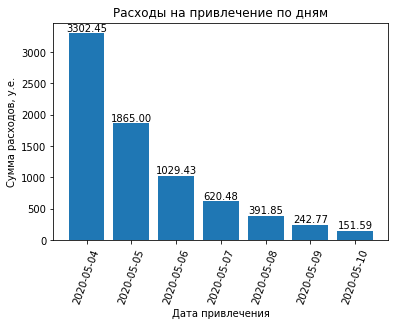

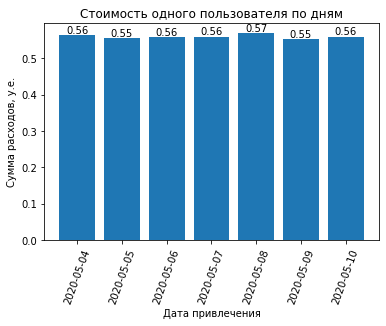

In [22]:
# Сколько потратили на привлечение в каждый день?
# визуализация
fig, ax = plt.subplots()
plt.xticks(rotation=70)
ax.bar(x=data_explore_2['day'], height=data_explore_2['cost'])
plt.bar_label(ax.containers[0], fmt='%.2f')
ax.set_title('Расходы на привлечение по дням')
ax.set_xlabel('Дата привлечения')
ax.set_ylabel('Сумма расходов, у.е.')

# Сколько стоит один пользователь каждой когорты
# визуализация
fig, ax = plt.subplots()
plt.xticks(rotation=70)
ax.bar(x=data_explore_2['day'], height=data_explore_2['cost_of_user'])
plt.bar_label(ax.containers[0], fmt='%.2f')
ax.set_title('Стоимость одного пользователя по дням')
ax.set_xlabel('Дата привлечения')
ax.set_ylabel('Сумма расходов, у.е.')

Расходы распределены неравномерно: основаная часть пришлась на первый день, каждый следующий сумма снижалась вдое. Стоимость пользователя между когортами не меняется, это хорошо. Жаль только, что они начинают меньше проходить уровень.

In [23]:
# Сколько стоит в среднем пользователь пользователь в исследовании?
mean_user_price = data_explore_2['cost'].sum() / data_explore_2['n_users'].sum()
print('Средняя стоимость пользователя в исследовании: ', round(mean_user_price, 3))

# Какое минимальное количество рекламы придеться на одного пользователя, чтобы окупить всю рекламу
print(f'Минимальное количество показов рекламы на пользователя: {math.ceil(mean_user_price/inner_ad_price)} при стоимости показа {inner_ad_price}')

# Какое минимальное кол-во объявлений придеться показать, чтобы окупить затраты
print(f'Минимальное количество показов рекламы: {math.ceil(data_explore_2["cost"].sum()/inner_ad_price)} при стоимости показа {inner_ad_price}')

Средняя стоимость пользователя в исследовании:  0.56
Минимальное количество показов рекламы на пользователя: 9 при стоимости показа 0.07
Минимальное количество показов рекламы: 108623 при стоимости показа 0.07


Определили минимальное количество рекламы, которое нужно показать, чтобы окупились затраты на привлечение пользователей. Число объявлений меньше, чем количество залогированных событий (135640), так что окупить точно можно (реклама будет везде).

## Количество событий в датасете в разбивке по когортам

Добавлю информацию о минимальном количестве объявлений для окупаемости когорты и о количестве разных событий, перед которыми можно показывать рекламу

In [24]:
# предварительный шаг - присоединю к таблице game_actions поле min_day из таблицы data_explore_1
game_actions = game_actions.merge(
                                right=data_explore_1[['user_id', 'min_day']],
                                how='left',
                                on='user_id'                     
)

In [25]:
# добавляю колонку с минимальным количеством объявлений
data_explore_2['n_min_ad'] = np.ceil(data_explore_2['cost'] / inner_ad_price).astype(int)

# добавлю к data_explore_2 колонку с количеством завершивших уровень
data_explore_2 = data_explore_2.merge(
                                        right=(game_actions.query('event == "finished_stage_1"').groupby('min_day', as_index=False).agg({'user_id': 'nunique'})),
                                        how='left',
                                        left_on='day',
                                        right_on='min_day'                                     
)
data_explore_2.rename(columns={'user_id': 'n_level_finished'}, inplace=True)
data_explore_2.drop(columns=['min_day'], inplace=True)
data_explore_2[['day', 'n_min_ad', 'n_level_finished']]


,day,n_min_ad,n_level_finished
0,2020-05-04,47178,2670
1,2020-05-05,26643,1513
2,2020-05-06,14707,771
3,2020-05-07,8864,412
4,2020-05-08,5598,235
5,2020-05-09,3469,134
6,2020-05-10,2166,82


Все числа минимум на порядок выше. Если показывать рекламу только по завершении уровня, привлечение игроков не окупится. А ведь есть и другие расходы...

In [26]:
# добавлю к data_explore_2 колонку с количеством завершивших проект
data_explore_2 = data_explore_2.merge(
                                        right=(game_actions.query('event == "project"').groupby('min_day', as_index=False).agg({'user_id': 'count'})),
                                        how='left',
                                        left_on='day',
                                        right_on='min_day'                                     
)
data_explore_2.rename(columns={'user_id': 'n_project_finished'}, inplace=True)
data_explore_2.drop(columns=['min_day'], inplace=True)
data_explore_2[['day', 'n_min_ad', 'n_project_finished']]

,day,n_min_ad,n_project_finished
0,2020-05-04,47178,921
1,2020-05-05,26643,496
2,2020-05-06,14707,242
3,2020-05-07,8864,113
4,2020-05-08,5598,47
5,2020-05-09,3469,35
6,2020-05-10,2166,12


Реклама после проектов тоже не окупит привлечение пользователей. Их даже меньше, потому что часть игроков воюет

In [27]:
# добавлю к data_explore_2 колонку с количеством построенных зданий, a также зданий разных типов
data_explore_2 = data_explore_2.merge(
                                        right=(game_actions.query('event == "building"').groupby('min_day', as_index=False).agg({'user_id': 'count'})),
                                        how='left',
                                        left_on='day',
                                        right_on='min_day'                                     
)
data_explore_2.rename(columns={'user_id': 'n_buildings_finished'}, inplace=True)
data_explore_2.drop(columns=['min_day'], inplace=True)

# цеха
data_explore_2 = data_explore_2.merge(
                                        right=(game_actions.query('building_type == "assembly_shop"').groupby('min_day', as_index=False).agg({'user_id': 'count'})),
                                        how='left',
                                        left_on='day',
                                        right_on='min_day'                                     
)
data_explore_2.rename(columns={'user_id': 'n_assembly_shops_finished'}, inplace=True)
data_explore_2.drop(columns=['min_day'], inplace=True)

# космопорты
data_explore_2 = data_explore_2.merge(
                                        right=(game_actions.query('building_type == "spaceport"').groupby('min_day', as_index=False).agg({'user_id': 'count'})),
                                        how='left',
                                        left_on='day',
                                        right_on='min_day'                                     
)
data_explore_2.rename(columns={'user_id': 'n_spaceports_finished'}, inplace=True)
data_explore_2.drop(columns=['min_day'], inplace=True)

# исследовательские центры
data_explore_2 = data_explore_2.merge(
                                        right=(game_actions.query('building_type == "research_center"').groupby('min_day', as_index=False).agg({'user_id': 'count'})),
                                        how='left',
                                        left_on='day',
                                        right_on='min_day'                                     
)
data_explore_2.rename(columns={'user_id': 'n_research_centers_finished'}, inplace=True)
data_explore_2.drop(columns=['min_day'], inplace=True)

data_explore_2[['day', 'n_min_ad', 'n_buildings_finished', 'n_assembly_shops_finished', 'n_spaceports_finished', 'n_research_centers_finished']]

,day,n_min_ad,n_buildings_finished,n_assembly_shops_finished,n_spaceports_finished,n_research_centers_finished
0,2020-05-04,47178,60635,28029,25758,6848
1,2020-05-05,26643,32747,14400,14587,3760
2,2020-05-06,14707,16386,6621,7994,1771
3,2020-05-07,8864,8904,3085,4866,953
4,2020-05-08,5598,4839,1401,3004,434
5,2020-05-09,3469,2856,656,1947,253
6,2020-05-10,2166,1589,302,1169,118


Показывать рекламу на некоторых постройках не удастся, их мало. Обнаружилась проблема даже с подходом показывать рекламу на каждой постройке: как было обнаружено ранее, доля закончивших первый уровень после 7 мая падает, и это не связано с тем, что они позже начали, так как горизонт логов значительно больше, чем среднее время на прохождение уровня. Эти пользователи явно меньше играют и меньше строят, когорты после 7 мая не смогут окупить сами себя, если показывать только одну рекламу на одну постройку.

Дальнейшие варианты:
* Признать данные после 5 мая неудовлетворительными и исключить их из анализа (доля проходящих первый уровень начала стремительно падать, маркетинг начал привлекать худшую аудиторию, в таких условиях модель не построить)
* Рассчитывать окупаемость по данным всего исследования, а не по когортам. В моем представлении каждая когорта должна окупать себя, а также они должны быть примерно одинаковыми по пользователям. В нашем случае бюджет распределен неравномерно, в последние дни приходит меньше игроков. Возможно, им не с кем играть и они отваливаются быстрее, о чем свидетельствует снизившаяся доля прохождения первого уровня.

Я выбираю второй вариант.

## Модель

In [28]:
# складываю все, что посчитали выше
data_explore_2.loc['total'] = data_explore_2.sum()
data_explore_2.loc['total']

/tmp/ipykernel_48/4007637828.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_explore_2.loc['total'] = data_explore_2.sum()


day                                    NaT
cost                           7603.576987
n_users                            13576.0
cost_of_user                       3.91598
n_min_ad                          108625.0
n_level_finished                    5817.0
n_project_finished                  1866.0
n_buildings_finished              127956.0
n_assembly_shops_finished          54494.0
n_spaceports_finished              59325.0
n_research_centers_finished        14137.0
Name: total, dtype: object

Исходя чисел выше, есть несколько простых вариантов окупить привлечение игроков: показывать рекламу во время каждой постройки, или показывать рекламу во время постройки мастерской и космопорта. Есть и третий вариант: показывать рекламу на всех постройках, но дать каждому пользователю построить одно здание без рекламы, чтобы не отпугнуть его рекламой сразу. А к второй постройке объяснить: "Чтобы делать любимую игру еще лучше и содержать быстрые сервера, мы показываем вам рекламу во время постройки вашего здания. Мы не продаем ваши данные и ценим наших игроков". Это будет простая и справедливая базовая модель, которую потом можно развивать: нравится наша игра и не нравится реклама при постройке здания - жди дольше или оплачивай подписку, которая даст... Проверим, сработает ли такая модель

In [29]:
# пропускаем один показ
# затраты
costs = ad_costs['cost'].sum()

# выручка
income = (len(game_actions.query('event == "building"')) - len(user_source)) * inner_ad_price

# проверка:
if costs <= income:
    print(f'Окупаемся, прибыль составила {round((income - costs), 2)} у.е.')
else:
    print(f'Не окупаемся, убыток составил {round((costs - income), 2)} у.е.')

Окупаемся, прибыль составила 403.02 у.е.


Окупаемся! А что будет, если пропустить два показа?

In [30]:
# пропускаем два показа
# затраты
costs = ad_costs['cost'].sum()

# выручка
income = (len(game_actions.query('event == "building"')) - 2 * len(user_source)) * inner_ad_price

# проверка:
if costs <= income:
    print(f'Окупаемся, прибыль составила {round((income - costs), 2)} у.е.')
else:
    print(f'Не окупаемся, убыток составил {round((costs - income), 2)} у.е.')

Не окупаемся, убыток составил 547.3 у.е.


К сожалению, уже не окупаемся.

Предложенная модель окупает привлечение пользователей, участвующих в исследовании, и приносит прибыль 403 у.е. Можно еще незначительно уменьшить количетсво рекламы за счет выделения среди пользователей особых категорий, или случайным образом распределять рекламные объявления, но это может вызвать негативную реацию пользователей. Предложенная система справедлива и является компромиссом между выдвинутыми требованиями. 

# Проверка статистических гипотез

**Гипотеза 1**
Время прохождения уровня между игроками, которые реализуют проект или побеждают игрока для перехода к следующему уровню, равно или отличается. Время прохождения уровня - дельта тайм между событием завершения уровня и первым действием. Нужно собрать две выборки: со временем прохождения каждого строителя и со временем прохождения каждого воина, а затем сравнить их, используя тест U-критерий
Манна-Уитни, так как в данных могут быть выбросы. В таком случае:
* Нулевая гипотеза: среднее время прохождения уровня у строителей и воинов равно
* Альтернативная гипотеза: среднее время прохождения уровня у строителей и воинов отличается
* Уровень значимости стандартный 0,05

**Гипотеза 2**
Время прохождения уровня всеми пользователями распределено нормально. Для проверки гипотезы буду использовать критерий Шапиро-Уилка.
* Нулевая гипотеза: время прохождения уровня распределено нормально
* Альтернативная гипотеза: распределение времени прохождения уровня отличается от нормального
* Уровень значимости стандартный 0,05

В обоих случаях дельтатайм будет переведен в количество часов (сейчас оно в минутах)

## Проверка гипотезы 1

In [31]:
# проверка гипотезы 1

# формирую наборы для теста
data_warriors = data_explore_1.query('game_style == "varrior"')
data_warriors['time_for_level_hours'] = (data_warriors['time_for_level'] // 60).astype(int)
warriors_time = data_warriors['time_for_level_hours'].to_list()

data_builders = data_explore_1.query('game_style == "builder"')
data_builders['time_for_level_hours'] = (data_builders['time_for_level'] // 60).astype(int)
builders_time = data_builders['time_for_level_hours'].to_list()

#  рассчитываю p-value
print("p-value: {0:.3f}".format(
    stats.mannwhitneyu(
        warriors_time,
        builders_time)[1]))

# рассчитываю средние
print('Разница во времени прохождения уровня между строителями и воинами, ч: ', round((sum(builders_time)/len(builders_time) - sum(warriors_time)/len(warriors_time)), 2))

p-value: 0.000
Разница во времени прохождения уровня между строителями и воинами, ч:  56.5


/tmp/ipykernel_48/2010780004.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_warriors['time_for_level_hours'] = (data_warriors['time_for_level'] // 60).astype(int)
/tmp/ipykernel_48/2010780004.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_builders['time_for_level_hours'] = (data_builders['time_for_level'] // 60).astype(int)


p-value значительно меньше уровня значимости, значит нулевая гипотеза отвергается и время между разными типами игроков различается значительно. И действительно, разница около 56 часов - больше двух суток. Гипотеза опровергнута.

## Проверка гипотезы 2

/tmp/ipykernel_48/2119549185.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_time_for_level['time_for_level_hours'] = (data_time_for_level['time_for_level'] / 60)
/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-value: 3.076167265094915e-22


Text(0, 0.5, 'Кол-во пользователей')

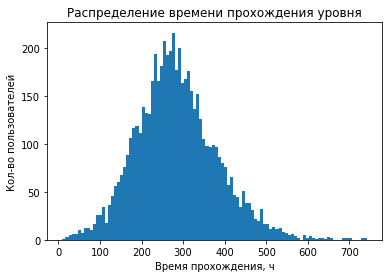

In [32]:
# проверка гипотезы 2

# формирую набор для теста
data_time_for_level = data_explore_1[data_explore_1['is_level_finished'] == True]
data_time_for_level['time_for_level_hours'] = (data_time_for_level['time_for_level'] / 60)
time_for_level = data_time_for_level['time_for_level_hours'].to_list()

#  рассчитываю p-value
print("p-value: {}".format(
    stats.shapiro(time_for_level)[1]))


# визуализирую
fig, ax = plt.subplots()
ax.hist(time_for_level, bins=100)
ax.set_title('Распределение времени прохождения уровня')
ax.set_xlabel('Время прохождения, ч')
ax.set_ylabel('Кол-во пользователей')

p-value снова около 0, значит нулевая гипотеза отвергается и данные распределены не нормально. На гистограмме виден хвост и пики на определенных часах. Хотя визуально распределение может показаться похожим на нормальное, тест это опровергает.

## Проверка гипотезы 2 (актуальная)

**Гипотеза 2**
Рабочая гипотеза: количество построек не зависит от стиля игры, а значит строители и воины будут видеть одинаковое количество рекламы. Для проверки гипотезы буду использовать U-критерий
Манна-Уитни.
* Нулевая гипотеза H0: среднее кол-во построек у строителей и воителей равно
* Альтернативная гипотеза H1: среднее кол-во построек у строителей и воителей различается
* Уровень значимости стандартный 0,05

In [34]:
# проверка гипотезы 2

# формирую наборы для теста
data_warriors = data_explore_1.query('game_style == "varrior"')
warriors_n_builded = data_warriors['n_builded'].to_list()

data_builders = data_explore_1.query('game_style == "builder"')
builders_n_builded = data_builders['n_builded'].to_list()

#  рассчитываю p-value
print("p-value: {0:.3f}".format(
    stats.mannwhitneyu(
        warriors_n_builded,
        builders_n_builded)[1]))

# рассчитываю средние
print('Разница по количеству построек между строителями и воинами: ', round((sum(builders_n_builded)/len(builders_n_builded) - sum(warriors_n_builded)/len(warriors_n_builded)), 2))

p-value: 0.000
Разница по количеству построек между строителями и воинами:  3.24


p-value меньше уровня значимости, нулевая гипотеза отвергается, принимается гипотеза H1 - среднее кол-во построек между строителями и воителями отличается, строители строят на 3.24 постройки больше. Они будут видеть рекламу чаще из-за своего стиля игры. Делать ли с этим что-то, нужно решать вместе.

# Общие выводы

В результате работы над проектом:
1. Исследованы факторы, сопровождающие достижение целевого события - прохождение первого уровня:
    1. В среднем прохождение уровня занимает 11 дней, доля игроков, завершивших уровень - 0,42. Рекомендуется сопоставить длительность прохождения уровня с другими мобильными играми
    2. С увеличением даты привлечения пользователей доля закончивших уровень снижается. Бюджет распределен неравномерно, и, возможно, новым игрокам не с кем играть. Рекомендуется проверить, что тип привлекаемых пользователей не изменился.
    3. Время завершения уровня и доля завершивших игроков не зависит от канала привлечения. Количество построек и их типов тоже отличается незначительно.
    4. Воины заканчивают уровень быстрее (11 дней) и имеют меньше построек (9,4), чем строители (почти 14 дней и 12,6 построек).
2. Предложена базовая модель монетизации: Показ рекламы на экране всех построек, кроме первой для каждого игрока. С такой моделью пользователи, участвовавшие в исследовании окупаются и приносят прибыль 403.02 у.е.
3. Проверены и опровергнуты две гипотезы, в действительности:
    1. Время прохождения уровня игроками-воинами и игроками-строителями различается
    2. Среднее количество построек между игроками-воинами и игроками-строителями различается

Рекомендуется:
1. Оценить среднее время прохождения уровня и сравнить его с другими играми
2. Проверить, что параметры привлекаемых людей не изменились и снижение доли прошедших уровней связано с количетсвом игроков.
3. Имитационно развернуть базовую модель на часть пользователей (не показывать рекламу, а просчитывать доход). При реальном внедрении модели нужно учесть возможное падение удержание пользователей.

# Материалы

[Ссылка](https://drive.google.com/file/d/1KJy2YXMHvb_pCWTs41xrZ_cp_LbCd6l0/view?usp=share_link) на презентацию с выводами по исследованию

[Ссылка](https://public.tableau.com/views/Book3_16801811305550/sheet2?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link) на дашборд